In [3]:
# ===== INSTRUMENTAL AND REDUCTION PARAMETERS =====
# GAIN and RON will be read from FITS header
ZEROPOINT = 25.0        # instrumental zeropoint (fixed)

# Detection parameters - WILL TEST MULTIPLE THRESHOLDS
SIGMA_THRESHOLDS = [2.0, 1.5, 1.2]  # detection thresholds to test (sigma)
NPIX_MIN = 6 # minimum pixels for detection

# Segmentation parameters
NLEVELS = 32            # deblending levels
CONTRAST = 0.005        # deblending contrast

# Background parameters
SIZE_BKG_REG = 100      # background region size (arcsec)
BS = 3                  # filter window size for background
MTH = 2                 # mask threshold (times RMS)
SS = 0.02               # fraction of outer image to ignore

# Photometry parameters - WILL TEST MULTIPLE APERTURES
APERTURE_RADII = [2.0, 3.0, 4.0, 5.0]  # fixed aperture radii to test (pixels)

# Matching and photometry
MATCH_TOLERANCE = 2.0   # matching tolerance (pixels)
MAG_LIMIT = 30.0        # maximum valid magnitude
DEFAULT_ERROR_2MASS = 0.33  # default 2MASS error
VSX_POSITION_ERROR = 1.0    # VSX position error (arcsec)

# ===== IMPORTS =====
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from photutils.segmentation import detect_sources, deblend_sources, SourceCatalog
from photutils.aperture import CircularAperture, aperture_photometry
import requests
import pandas as pd
from io import StringIO
from scipy.spatial import cKDTree
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Parameters and imports loaded")
print(f"  Testing {len(SIGMA_THRESHOLDS)} thresholds: {SIGMA_THRESHOLDS} σ")
print(f"  Testing {len(APERTURE_RADII)} apertures: {APERTURE_RADII} pixels")
print(f"  Total combinations: {len(SIGMA_THRESHOLDS) * len(APERTURE_RADII)}")

✓ Parameters and imports loaded
  Testing 3 thresholds: [2.0, 1.5, 1.2] σ
  Testing 4 apertures: [2.0, 3.0, 4.0, 5.0] pixels
  Total combinations: 12


In [4]:
# ===== MODIFY THIS =====
FITS_FILE = '/Users/matteoferro/Desktop/GRB/REM/process_REMIR/test_2026/proc/reduced/1A0538_66_330663_1_J_astro.fits'

print(f"Target file: {FITS_FILE}")

Target file: /Users/matteoferro/Desktop/GRB/REM/process_REMIR/test_2026/proc/reduced/1A0538_66_330663_1_J_astro.fits


STEP 1: Loading FITS file
  File: /Users/matteoferro/Desktop/GRB/REM/process_REMIR/test_2026/proc/reduced/1A0538_66_330663_1_J_astro.fits
  Shape: (512, 512)
  Filter: J
  Pixel scale: 1.221 arcsec/pixel
  Center: RA=83.9209, DEC=-66.8649
  PSTATSUB: 4
  NDITHERS: 5
  NDIT: 1
  Image type: DITHERED (5 images summed)
  GAIN (single): 5.0 e-/ADU
  GAIN (effective): 1.0000 e-/ADU
  RON: 100.0 e-


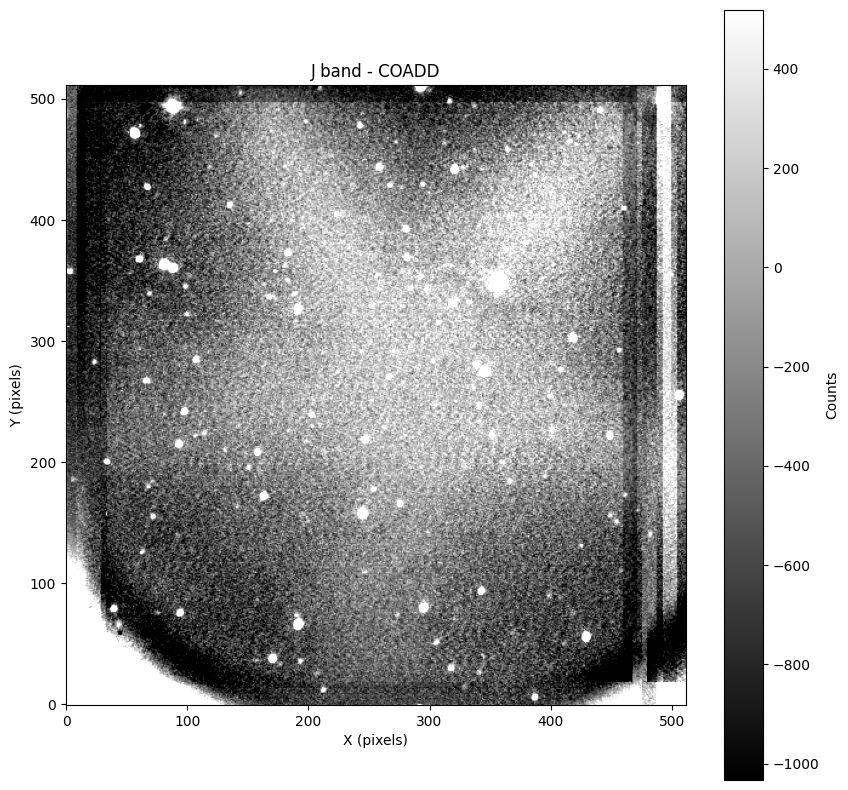

✓ FITS loaded successfully



In [7]:
print("="*70)
print("STEP 1: Loading FITS file")
print("="*70)

with fits.open(FITS_FILE) as hdul:
    data = hdul[0].data
    header = hdul[0].header
    wcs = WCS(header)
    
    # Handle multi-dimensional data
    if data.ndim > 2:
        if data.ndim == 3:
            data = data[0]
        elif data.ndim == 4:
            data = data[0, 0]
    
    # Ensure correct byte order
    if not data.dtype.isnative:
        data = data.astype(data.dtype.newbyteorder("="))
    data = data.astype(np.float32)
    
    # Extract metadata
    filter_name = header.get('FILTER', 'H').strip().upper()
    if filter_name in ['H2', 'Z']:
        filter_name = 'H'
    
    # Pixel scale
    try:
        pixel_scale = np.abs(header['PIXSCALE'])
    except:
        pixel_scale = 1.2
    
    # Center coordinates
    height, width = data.shape
    if 'RA' in header and 'DEC' in header:
        ra_center = header['RA']
        dec_center = header['DEC']
    elif 'CRVAL1' in header and 'CRVAL2' in header:
        ra_center = header['CRVAL1']
        dec_center = header['CRVAL2']
    else:
        ra_center, dec_center = wcs.all_pix2world(width/2, height/2, 0)
    
    # Check if coadd or single
    PSTATSUB = header.get('PSTATSUB', 3)
    NDITHERS = header.get('NDITHERS', 1)
    NDIT = header.get('NDIT', 1)  # Number of non-dithered coadds
    
    is_coadd = (PSTATSUB == 4)
    
    # Read GAIN and RON from header
    GAIN_SINGLE = header.get('GAIN', 2.0)  # e-/ADU for single image
    RON = header.get('RDNOISE', header.get('RON', 5.0))  # e-
    
    # Calculate effective GAIN for coadd images
    # For coadded images, GAIN must be scaled by number of summed frames
    if is_coadd:
        # Determine how many images were summed
        # Priority logic: if both > 1, the HIGHER value wins
        if NDITHERS > 1 and NDIT > 1:
            if NDITHERS > NDIT:
                # Higher NDITHERS wins -> dithered coadd
                n_summed = NDITHERS
                coadd_type = "DITHERED"
            else:
                # Higher NDIT wins -> non-dithered coadd
                n_summed = NDIT
                coadd_type = "NON-DITHERED"
        elif NDITHERS > 1:
            # Only NDITHERS > 1 -> dithered coadd
            n_summed = NDITHERS
            coadd_type = "DITHERED"
        elif NDIT > 1:
            # Only NDIT > 1 -> non-dithered coadd
            n_summed = NDIT
            coadd_type = "NON-DITHERED"
        else:
            # Labeled as coadd but only 1 image?
            n_summed = 1
            coadd_type = "SINGLE (mislabeled)"
        
        # Scale GAIN: when N images are summed, flux increases by N but noise by √N
        # So effective gain (e-/ADU) decreases by factor of N
        GAIN_EFFECTIVE = GAIN_SINGLE / n_summed
    else:
        n_summed = 1
        coadd_type = "SINGLE"
        GAIN_EFFECTIVE = GAIN_SINGLE

print(f"  File: {FITS_FILE}")
print(f"  Shape: {data.shape}")
print(f"  Filter: {filter_name}")
print(f"  Pixel scale: {pixel_scale:.3f} arcsec/pixel")
print(f"  Center: RA={ra_center:.4f}, DEC={dec_center:.4f}")
print(f"  PSTATSUB: {PSTATSUB}")
print(f"  NDITHERS: {NDITHERS}")
print(f"  NDIT: {NDIT}")
print(f"  Image type: {coadd_type} ({n_summed} images summed)")
print(f"  GAIN (single): {GAIN_SINGLE} e-/ADU")
print(f"  GAIN (effective): {GAIN_EFFECTIVE:.4f} e-/ADU")
print(f"  RON: {RON} e-")

# Quick visualization
plt.figure(figsize=(10, 10))
plt.imshow(data, origin='lower', cmap='gray', 
           vmin=np.percentile(data, 5), vmax=np.percentile(data, 95))
plt.colorbar(label='Counts')
plt.title(f'{filter_name} band - {"COADD" if is_coadd else "SINGLE"}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.show()

print("✓ FITS loaded successfully\n")

STEP 2: Background Subtraction
  Box size: 64 px (~100.0 arcsec)
  Background median: -270.61
  Background RMS: 254.033


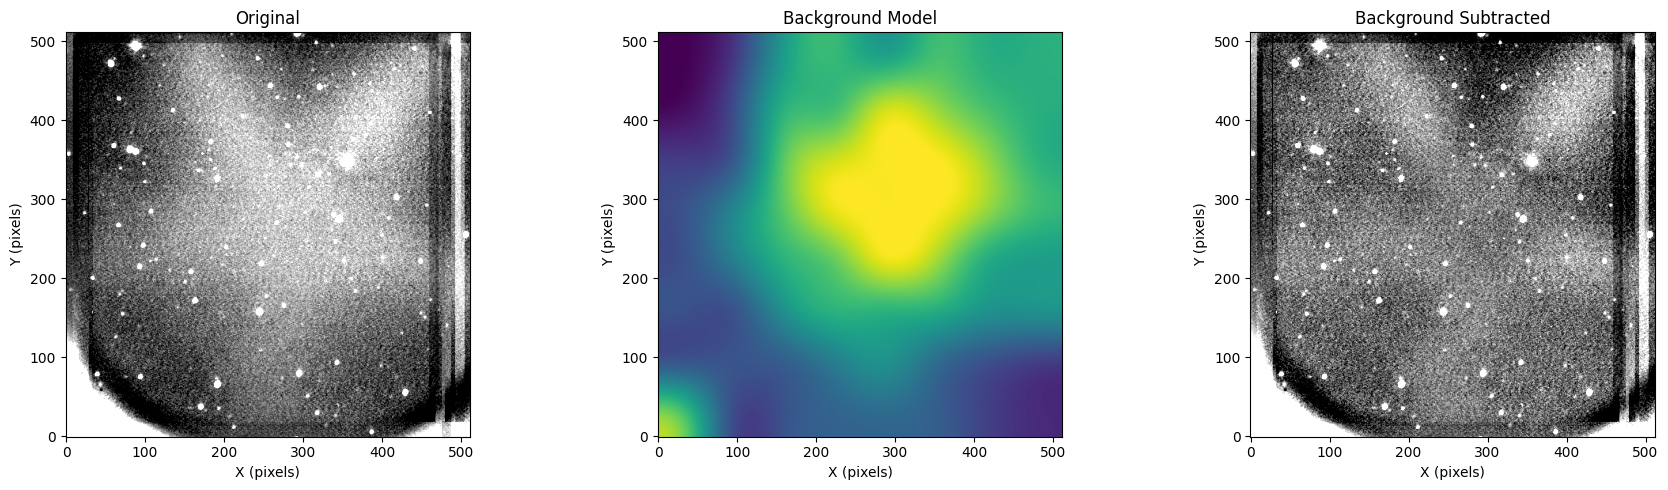

✓ Background subtraction complete



In [8]:
print("="*70)
print("STEP 2: Background Subtraction")
print("="*70)

def estimate_background(data, pixel_scale):
    """
    Estimate background using photutils
    """
    try:
        from photutils.background import Background2D, MedianBackground
        
        # Box size for background estimation
        desired_box = int(round(SIZE_BKG_REG / pixel_scale))
        allowed_sizes = np.array([16, 32, 64, 128])
        box_size = int(allowed_sizes[np.argmin(np.abs(allowed_sizes - desired_box))])
        
        # Estimate background
        bkg_estimator = MedianBackground()
        bkg = Background2D(data, box_size=(box_size, box_size), 
                          filter_size=(BS, BS), 
                          bkg_estimator=bkg_estimator)
        
        background_model = bkg.background
        background_rms_matrix = bkg.background_rms
        background_rms = np.median(bkg.background_rms)
        background_subtracted = data - background_model
        
        print(f"  Box size: {box_size} px (~{SIZE_BKG_REG:.1f} arcsec)")
        print(f"  Background median: {np.median(background_model):.2f}")
        print(f"  Background RMS: {background_rms:.3f}")
        
        return {
            'background_model': background_model,
            'background_rms': background_rms,
            'background_rms_matrix': background_rms_matrix,
            'background_subtracted': background_subtracted,
            'box_size': box_size
        }
    
    except Exception as e:
        print(f"  ERROR: Background estimation failed: {e}")
        return None

bkg_dict = estimate_background(data, pixel_scale)

if bkg_dict is None:
    raise RuntimeError("Background estimation failed!")

data_sub = bkg_dict['background_subtracted']
bkg_rms = bkg_dict['background_rms']
bkg_rms_matrix = bkg_dict['background_rms_matrix']
bkg_model = bkg_dict['background_model']

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(data, origin='lower', cmap='gray', 
               vmin=np.percentile(data, 5), vmax=np.percentile(data, 95))
axes[0].set_title('Original')
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')

axes[1].imshow(bkg_model, origin='lower', cmap='viridis')
axes[1].set_title('Background Model')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Y (pixels)')

axes[2].imshow(data_sub, origin='lower', cmap='gray', 
               vmin=np.percentile(data_sub, 5), vmax=np.percentile(data_sub, 95))
axes[2].set_title('Background Subtracted')
axes[2].set_xlabel('X (pixels)')
axes[2].set_ylabel('Y (pixels)')

for ax in axes:
    ax.grid(False)

plt.tight_layout()
plt.show()

print("✓ Background subtraction complete\n")

In [9]:
print("="*70)
print("STEP 3: Source Detection (Testing Multiple Thresholds)")
print("="*70)

def detect_sources_segmentation(data_sub, bkg_rms_matrix, bkg_rms, threshold_sigma):
    """
    Detect sources using segmentation with deblending
    """
    try:
        ny, nx = data_sub.shape
        
        # Threshold
        threshold = threshold_sigma * bkg_rms
        threshold_matrix = np.full_like(data_sub, threshold)
        
        print(f"  Testing threshold: {threshold:.3f} ({threshold_sigma}σ)")
        
        # Mask border region
        border_width = int(nx * SS)
        
        border_mask = np.zeros((ny, nx), dtype=bool)
        border_mask[:border_width, :] = True
        border_mask[-border_width:, :] = True
        border_mask[:, :border_width] = True
        border_mask[:, -border_width:] = True
        
        # Apply mask
        masked_data = data_sub.copy()
        masked_data[border_mask] = 0.0
        masked_threshold = threshold_matrix.copy()
        masked_threshold[border_mask] = np.inf
        
        # Initial segmentation
        initial_segment_map = detect_sources(
            masked_data, 
            masked_threshold, 
            npixels=NPIX_MIN, 
            connectivity=4
        )
        
        if initial_segment_map is None:
            print(f"    No sources detected!")
            return None
        
        initial_count = initial_segment_map.data.max()
        
        # Deblending
        segment_map = deblend_sources(
            masked_data,
            initial_segment_map,
            npixels=NPIX_MIN,
            nlevels=NLEVELS,
            contrast=CONTRAST,
            progress_bar=False
        )
        
        if segment_map is not None:
            final_count = segment_map.data.max()
        else:
            segment_map = initial_segment_map
            final_count = initial_count
        
        # Remove border labels
        segment_map.remove_border_labels(border_width=border_width)
        
        # Create source catalog
        source_catalog = SourceCatalog(data_sub, segment_map)
        source_table = source_catalog.to_table()
        
        # Calculate FWHM
        if 'semimajor_sigma' in source_table.colnames and 'semiminor_sigma' in source_table.colnames:
            sigma_avg = np.sqrt(source_table['semimajor_sigma'] * source_table['semiminor_sigma'])
            source_table['fwhm'] = 2.355 * sigma_avg
        
        print(f"    → Detected {len(source_table)} sources")
        
        return {
            'threshold_sigma': threshold_sigma,
            'segment_map': segment_map,
            'source_catalog': source_catalog,
            'source_table': source_table,
            'num_sources': len(source_table)
        }
    
    except Exception as e:
        print(f"    ERROR: Detection failed: {e}")
        return None

# Test all thresholds
detection_results = {}
print(f"\nTesting {len(SIGMA_THRESHOLDS)} detection thresholds...")

for threshold_sigma in SIGMA_THRESHOLDS:
    result = detect_sources_segmentation(data_sub, bkg_rms_matrix, bkg_rms, threshold_sigma)
    if result is not None:
        detection_results[threshold_sigma] = result

if len(detection_results) == 0:
    raise RuntimeError("No successful detections!")

print(f"\n✓ Successfully tested {len(detection_results)} thresholds")
print("  Detection summary:")
for thresh, result in detection_results.items():
    print(f"    {thresh}σ: {result['num_sources']} sources")

STEP 3: Source Detection (Testing Multiple Thresholds)

Testing 3 detection thresholds...
  Testing threshold: 508.065 (2.0σ)
    → Detected 271 sources
  Testing threshold: 381.049 (1.5σ)
    → Detected 484 sources
  Testing threshold: 304.839 (1.2σ)
    → Detected 834 sources

✓ Successfully tested 3 thresholds
  Detection summary:
    2.0σ: 271 sources
    1.5σ: 484 sources
    1.2σ: 834 sources


In [10]:
print("="*70)
print("STEP 4: Aperture Photometry (Testing Multiple Apertures)")
print("="*70)

def do_aperture_photometry_sextractor(source_table, data_sub, bkg_rms_matrix, aperture_radius, gain):
    """
    Perform aperture photometry with SExtractor-style error calculation
    
    SExtractor formula: FLUXERR = √(Σᵢ[σᵢ² + pᵢ·gᵢ])
    where:
    - σᵢ = local background RMS at pixel i (from bkg_rms_matrix)
    - pᵢ = background-subtracted pixel value
    - gᵢ = gain (e-/ADU)
    
    Note: For coadd images, GAIN in header should already be scaled appropriately
    """
    fluxes = []
    flux_errors = []
    snrs = []
    
    for source in source_table:
        x = source['xcentroid']
        y = source['ycentroid']
        
        # Create circular aperture
        aperture = CircularAperture((x, y), r=aperture_radius)
        
        # Get aperture mask
        aper_mask = aperture.to_mask(method='exact')
        
        if aper_mask is None:
            # Source too close to edge
            fluxes.append(0.0)
            flux_errors.append(np.inf)
            snrs.append(0.0)
            continue
        
        # Extract cutout data
        cutout = aper_mask.cutout(data_sub)
        cutout_rms = aper_mask.cutout(bkg_rms_matrix)
        
        if cutout is None or cutout_rms is None:
            fluxes.append(0.0)
            flux_errors.append(np.inf)
            snrs.append(0.0)
            continue
        
        # Get aperture weights (0 to 1 for fractional pixels)
        weights = aper_mask.data
        
        # Calculate flux (simple sum of background-subtracted pixels)
        flux = np.sum(cutout * weights)
        
        # SExtractor error formula: σ²_flux = Σᵢ[σᵢ² + pᵢ·gᵢ]
        # where sum is over pixels in aperture
        var_flux = 0.0
        for i in range(cutout.shape[0]):
            for j in range(cutout.shape[1]):
                w = weights[i, j]
                if w > 0:
                    pixel_value = cutout[i, j]  # background-subtracted (pᵢ)
                    local_rms = cutout_rms[i, j]  # σᵢ from background map
                    
                    # Variance contribution from this pixel
                    var_sky = local_rms**2  # sky variance in ADU²
                    var_source = max(pixel_value * gain, 0) / gain**2  # Poisson variance in ADU²
                    
                    var_flux += w**2 * (var_sky + var_source * gain)
        
        flux_error = np.sqrt(var_flux)
        snr = flux / flux_error if flux_error > 0 else 0
        
        fluxes.append(flux)
        flux_errors.append(flux_error)
        snrs.append(snr)
    
    return np.array(fluxes), np.array(flux_errors), np.array(snrs)

# Test all combinations of threshold + aperture
print(f"\nTesting {len(SIGMA_THRESHOLDS)} thresholds × {len(APERTURE_RADII)} apertures...")
print(f"Using SExtractor error formula: FLUXERR = √(Σ[σᵢ² + pᵢ·gᵢ])")
print(f"GAIN_EFFECTIVE = {GAIN_EFFECTIVE:.4f} e-/ADU (from header, scaled for coadd)\n")

photometry_results = {}

for threshold_sigma, det_result in detection_results.items():
    source_table = det_result['source_table'].copy()
    
    for aperture_radius in APERTURE_RADII:
        print(f"  Computing: {threshold_sigma}σ threshold, {aperture_radius}px aperture...", end=' ')
        
        fluxes, flux_errors, snrs = do_aperture_photometry_sextractor(
            source_table, data_sub, bkg_rms_matrix, aperture_radius, GAIN_EFFECTIVE
        )
        
        # Add to table copy
        phot_table = source_table.copy()
        phot_table['aperture_radius'] = aperture_radius
        phot_table['flux'] = fluxes
        phot_table['flux_err'] = flux_errors
        phot_table['snr'] = snrs
        
        # Calculate instrumental magnitudes
        phot_table['mag_inst'] = ZEROPOINT - 2.5 * np.log10(np.maximum(fluxes, 1e-10))
        phot_table['mag_inst_err'] = 2.5 / np.log(10) * flux_errors / np.maximum(fluxes, 1e-10)
        
        # Store result
        key = (threshold_sigma, aperture_radius)
        photometry_results[key] = {
            'threshold_sigma': threshold_sigma,
            'aperture_radius': aperture_radius,
            'source_table': phot_table,
            'median_snr': np.median(snrs)
        }
        
        print(f"→ {len(phot_table)} sources, median SNR={np.median(snrs):.1f}")

print(f"\n✓ Tested {len(photometry_results)} combinations")
print("  Summary:")
for key, result in sorted(photometry_results.items()):
    thresh, aper = key
    print(f"    {thresh}σ, {aper}px: {len(result['source_table'])} sources, SNR={result['median_snr']:.1f}")

STEP 4: Aperture Photometry (Testing Multiple Apertures)

Testing 3 thresholds × 4 apertures...
Using SExtractor error formula: FLUXERR = √(Σ[σᵢ² + pᵢ·gᵢ])
GAIN_EFFECTIVE = 1.0000 e-/ADU (from header, scaled for coadd)

  Computing: 2.0σ threshold, 2.0px aperture... → 271 sources, median SNR=7.8
  Computing: 2.0σ threshold, 3.0px aperture... → 271 sources, median SNR=9.6
  Computing: 2.0σ threshold, 4.0px aperture... → 271 sources, median SNR=10.3
  Computing: 2.0σ threshold, 5.0px aperture... → 271 sources, median SNR=11.7
  Computing: 1.5σ threshold, 2.0px aperture... → 484 sources, median SNR=5.9
  Computing: 1.5σ threshold, 3.0px aperture... → 484 sources, median SNR=6.8
  Computing: 1.5σ threshold, 4.0px aperture... → 484 sources, median SNR=7.8
  Computing: 1.5σ threshold, 5.0px aperture... → 484 sources, median SNR=8.8
  Computing: 1.2σ threshold, 2.0px aperture... → 834 sources, median SNR=4.9
  Computing: 1.2σ threshold, 3.0px aperture... → 834 sources, median SNR=5.6
  Comput

In [11]:
print("="*70)
print("STEP 5: Query 2MASS Catalog")
print("="*70)

# Calculate search radius
max_dimension = max(width, height)
try:
    ra_corner, dec_corner = wcs.all_pix2world(max_dimension, max_dimension, 0)
    center_coord = SkyCoord(ra=ra_center*u.deg, dec=dec_center*u.deg)
    corner_coord = SkyCoord(ra=ra_corner*u.deg, dec=dec_corner*u.deg)
    radius_deg = center_coord.separation(corner_coord).deg * 1.5
except:
    radius_deg = (max_dimension * pixel_scale / 3600.0) * 1.5

if radius_deg > 1.0:
    print(f"  WARNING: radius {radius_deg:.2f} deg too large, limiting to 1.0 deg")
    radius_deg = 1.0

print(f"  Center: RA={ra_center:.4f}, DEC={dec_center:.4f}")
print(f"  Radius: {radius_deg:.4f} deg ({radius_deg*60:.2f} arcmin)")

# Query 2MASS
url_2mass = (
    f"https://cats.oas.inaf.it/2mass/"
    f"radius={radius_deg}&ra={ra_center}&dec={dec_center}&limit=10000&csv"
)

print(f"  Querying 2MASS...")
response = requests.get(url_2mass, timeout=60)
df_2mass = pd.read_csv(StringIO(response.text))

print(f"  Downloaded {len(df_2mass)} sources")

# Find RA/DEC columns
colnames_lower = {c.lower(): c for c in df_2mass.columns}
ra_col = next(c for c in df_2mass.columns if "raj2000" in c.lower())
dec_col = next(c for c in df_2mass.columns if "dej2000" in c.lower())

# Filter band
band = filter_name.upper()
if band not in df_2mass.columns:
    raise ValueError(f"Filter '{filter_name}' not found in 2MASS catalog!")

mag_col = band
err_col = f"e{band}" if f"e{band}" in df_2mass.columns else None

print(f"  Using band: {band}")
print(f"  Magnitude column: {mag_col}")
if err_col:
    print(f"  Error column: {err_col}")

# Filter valid magnitudes
valid = df_2mass[mag_col].notna() & (df_2mass[mag_col] < MAG_LIMIT) & (df_2mass[mag_col] > 0)
df_2mass = df_2mass[valid]

# Convert to pixels
ra_vals = df_2mass[ra_col].values
dec_vals = df_2mass[dec_col].values
x_pix, y_pix = wcs.all_world2pix(ra_vals, dec_vals, 0)

# Build catalog
catalog_2mass = Table()
catalog_2mass['ra'] = ra_vals
catalog_2mass['dec'] = dec_vals
catalog_2mass['x'] = x_pix
catalog_2mass['y'] = y_pix
catalog_2mass['mag'] = df_2mass[mag_col].values

if err_col:
    catalog_2mass['mag_err'] = df_2mass[err_col].fillna(DEFAULT_ERROR_2MASS).values
else:
    catalog_2mass['mag_err'] = np.full(len(df_2mass), DEFAULT_ERROR_2MASS)

print(f"  Valid 2MASS sources: {len(catalog_2mass)}")
print(f"  Magnitude range: {catalog_2mass['mag'].min():.2f} to {catalog_2mass['mag'].max():.2f}")

print("✓ 2MASS catalog loaded\n")

STEP 5: Query 2MASS Catalog
  Center: RA=83.9209, DEC=-66.8649
  Radius: 0.1566 deg (9.40 arcmin)
  Querying 2MASS...
  Downloaded 1436 sources
  Using band: J
  Magnitude column: J
  Error column: eJ
  Valid 2MASS sources: 1436
  Magnitude range: 8.36 to 18.04
✓ 2MASS catalog loaded



In [12]:
print("="*70)
print("STEP 6: Query VSX and Filter 2MASS")
print("="*70)

# Query VSX
url_vsx = (
    f"https://cats.oas.inaf.it/vsx/"
    f"radius={radius_deg}&ra={ra_center}&dec={dec_center}&limit=10000&csv"
)

preferred_ra_cols = ['RAJ2000', 'raj2000', 'ra']
preferred_dec_cols = ['DEJ2000', 'dej2000', 'dec']

def pick_column(columns, preferred_list):
    for pref in preferred_list:
        for col in columns:
            if col.lower() == pref.lower():
                return col
    for pref in preferred_list:
        for col in columns:
            if pref.lower() in col.lower():
                return col
    raise ValueError("No matching column found")

try:
    print(f"  Querying VSX...")
    response = requests.get(url_vsx, timeout=60)
    df_vsx = pd.read_csv(StringIO(response.text))
    
    if df_vsx.empty:
        print("  No VSX sources found")
        vsx_table = Table(names=['ra', 'dec'], dtype=[float, float])
    else:
        print(f"  Downloaded {len(df_vsx)} VSX sources")
        
        ra_col_vsx = pick_column(df_vsx.columns, preferred_ra_cols)
        dec_col_vsx = pick_column(df_vsx.columns, preferred_dec_cols)
        
        vsx_table = Table()
        vsx_table['ra'] = df_vsx[ra_col_vsx].values
        vsx_table['dec'] = df_vsx[dec_col_vsx].values

except Exception as e:
    print(f"  WARNING: VSX query failed: {e}")
    vsx_table = Table(names=['ra', 'dec'], dtype=[float, float])

# Filter 2MASS (exclude VSX)
if len(vsx_table) == 0:
    print("  No VSX sources to filter")
    catalog_2mass_filtered = catalog_2mass
else:
    print(f"  Filtering 2MASS (excluding VSX)...")
    coords_2mass = SkyCoord(ra=catalog_2mass['ra']*u.deg, dec=catalog_2mass['dec']*u.deg)
    coords_vsx = SkyCoord(ra=vsx_table['ra']*u.deg, dec=vsx_table['dec']*u.deg)
    
    keep_mask = np.ones(len(catalog_2mass), dtype=bool)
    
    for i, coord_2mass in enumerate(coords_2mass):
        sep = coord_2mass.separation(coords_vsx).arcsec
        if np.any(sep < VSX_POSITION_ERROR):
            keep_mask[i] = False
    
    catalog_2mass_filtered = catalog_2mass[keep_mask]
    
    print(f"  Excluded {np.sum(~keep_mask)} 2MASS sources matching VSX")
    print(f"  Remaining: {len(catalog_2mass_filtered)} non-variable 2MASS sources")

print("✓ VSX filtering complete\n")

STEP 6: Query VSX and Filter 2MASS
  Querying VSX...
  Downloaded 261 VSX sources
  Filtering 2MASS (excluding VSX)...
  Excluded 133 2MASS sources matching VSX
  Remaining: 1303 non-variable 2MASS sources
✓ VSX filtering complete



In [13]:
print("="*70)
print("STEP 7: Match All Combinations with 2MASS")
print("="*70)

print(f"  Matching tolerance: {MATCH_TOLERANCE} pixels")
print(f"  Testing {len(photometry_results)} combinations...\n")

# Build KD-tree for catalog
catalog_coords = np.column_stack([catalog_2mass_filtered['x'], catalog_2mass_filtered['y']])
tree = cKDTree(catalog_coords)

matching_results = {}

for key, phot_result in photometry_results.items():
    thresh, aper = key
    source_table = phot_result['source_table']
    
    print(f"  Matching {thresh}σ, {aper}px ({len(source_table)} sources)...", end=' ')
    
    # Get detection positions
    detected_coords = np.column_stack([source_table['xcentroid'], source_table['ycentroid']])
    distances, indices = tree.query(detected_coords, k=1)
    
    # Keep only within tolerance
    valid_mask = distances < MATCH_TOLERANCE
    
    # Ensure uniqueness
    matched_pairs = {}
    for det_idx in np.where(valid_mask)[0]:
        cat_idx = indices[det_idx]
        dist = distances[det_idx]
        if cat_idx not in matched_pairs or dist < matched_pairs[cat_idx][1]:
            matched_pairs[cat_idx] = (det_idx, dist)
    
    # Extract unique pairs
    matched_det_indices = [pair[0] for pair in matched_pairs.values()]
    matched_cat_indices = list(matched_pairs.keys())
    
    matched_detected = source_table[matched_det_indices]
    matched_catalog = catalog_2mass_filtered[matched_cat_indices]
    
    print(f"→ {len(matched_detected)} matches")
    
    matching_results[key] = {
        'threshold_sigma': thresh,
        'aperture_radius': aper,
        'source_table': source_table,
        'matched_detected': matched_detected,
        'matched_catalog': matched_catalog,
        'matched_det_indices': matched_det_indices,
        'matched_cat_indices': matched_cat_indices,
        'n_matches': len(matched_detected)
    }

print(f"\n✓ Matching complete for all combinations")
print("  Match summary:")
for key, result in sorted(matching_results.items()):
    thresh, aper = key
    print(f"    {thresh}σ, {aper}px: {result['n_matches']} matches")

STEP 7: Match All Combinations with 2MASS
  Matching tolerance: 2.0 pixels
  Testing 12 combinations...

  Matching 2.0σ, 2.0px (271 sources)... → 106 matches
  Matching 2.0σ, 3.0px (271 sources)... → 106 matches
  Matching 2.0σ, 4.0px (271 sources)... → 106 matches
  Matching 2.0σ, 5.0px (271 sources)... → 106 matches
  Matching 1.5σ, 2.0px (484 sources)... → 137 matches
  Matching 1.5σ, 3.0px (484 sources)... → 137 matches
  Matching 1.5σ, 4.0px (484 sources)... → 137 matches
  Matching 1.5σ, 5.0px (484 sources)... → 137 matches
  Matching 1.2σ, 2.0px (834 sources)... → 173 matches
  Matching 1.2σ, 3.0px (834 sources)... → 173 matches
  Matching 1.2σ, 4.0px (834 sources)... → 173 matches
  Matching 1.2σ, 5.0px (834 sources)... → 173 matches

✓ Matching complete for all combinations
  Match summary:
    1.2σ, 2.0px: 173 matches
    1.2σ, 3.0px: 173 matches
    1.2σ, 4.0px: 173 matches
    1.2σ, 5.0px: 173 matches
    1.5σ, 2.0px: 137 matches
    1.5σ, 3.0px: 137 matches
    1.5σ, 4.0p

In [14]:
print("="*70)
print("STEP 8: Calibration - Find Best Combination")
print("="*70)

# Calibration filtering parameters
MIN_ISOLATION_DIST = 7.0  # minimum distance between sources (pixels) for isolation
CENTRAL_FRACTION = 0.90   # use central 90% of image (avoid 10% border)

def fit_zeropoint_iterative(mag_inst, mag_cat, mag_inst_err, mag_cat_err, 
                            max_iterations=10, sigma_clip=3.0, verbose=False):
    """
    Fit zeropoint with iterative sigma clipping
    """
    mask = np.ones(len(mag_inst), dtype=bool)
    iteration = 0
    
    while iteration < max_iterations:
        mi = mag_inst[mask]
        mc = mag_cat[mask]
        ei = mag_inst_err[mask]
        ec = mag_cat_err[mask]
        
        err_combined = np.sqrt(ec**2 + ei**2)
        zps = mc - mi
        
        weights = 1.0 / err_combined**2
        zp_mean = np.sum(zps * weights) / np.sum(weights)
        zp_err = 1.0 / np.sqrt(np.sum(weights))
        
        residuals = mc - (mi + zp_mean)
        rms = np.sqrt(np.mean(residuals**2))
        
        outliers = np.abs(residuals) > sigma_clip * rms
        
        if not np.any(outliers):
            if verbose:
                print(f"    Iteration {iteration+1}: Converged")
            break
        
        outlier_indices = np.where(mask)[0][outliers]
        mask[outlier_indices] = False
        
        if verbose:
            print(f"    Iteration {iteration+1}: Rejected {np.sum(outliers)} outliers (RMS={rms:.3f})")
        
        iteration += 1
    
    n_used = np.sum(mask)
    n_total = len(mask)
    
    return zp_mean, zp_err, rms, mask, n_used, n_total

def get_isolation_mask(source_table, min_distance=7.0):
    """
    Return mask for isolated sources (no neighbors within min_distance pixels)
    """
    positions = np.column_stack([source_table['xcentroid'], source_table['ycentroid']])
    tree = cKDTree(positions)
    
    # Query for neighbors within min_distance (excluding self with k=2)
    distances, indices = tree.query(positions, k=2, distance_upper_bound=min_distance)
    
    # Isolated = no second neighbor within min_distance
    # (distance to second neighbor is inf or >= min_distance)
    isolated_mask = distances[:, 1] >= min_distance
    
    return isolated_mask

def get_central_mask(source_table, image_shape, central_fraction=0.90):
    """
    Return mask for sources in central region of image
    """
    ny, nx = image_shape
    
    # Calculate central region boundaries
    border_x = (1.0 - central_fraction) / 2.0 * nx
    border_y = (1.0 - central_fraction) / 2.0 * ny
    
    x_min = border_x
    x_max = nx - border_x
    y_min = border_y
    y_max = ny - border_y
    
    x = source_table['xcentroid']
    y = source_table['ycentroid']
    
    central_mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
    
    return central_mask

print(f"\nTesting calibration for {len(matching_results)} combinations...")
print(f"  Isolation criterion: sources > {MIN_ISOLATION_DIST} px apart")
print(f"  Central region: inner {CENTRAL_FRACTION*100:.0f}% of image")
print(f"  Testing 4 filtering strategies:\n")
print(f"    1. ISOLATE+CENTRAL: isolated sources in central region")
print(f"    2. ISOLATE: isolated sources only")
print(f"    3. CENTRAL: central sources only")
print(f"    4. ALL: all matched sources\n")

calibration_results = {}
DEFAULT_ERR = 0.05

# Define the 4 filtering strategies
FILTER_STRATEGIES = [
    ('isolate+central', 'Isolate+Central'),
    ('isolate', 'Isolate'),
    ('central', 'Central'),
    ('all', 'All')
]

for key, match_result in matching_results.items():
    thresh, aper = key
    
    if match_result['n_matches'] < 3:
        print(f"  {thresh}σ, {aper}px: SKIP (only {match_result['n_matches']} matches)")
        continue
    
    matched_detected = match_result['matched_detected']
    matched_catalog = match_result['matched_catalog']
    source_table_full = match_result['source_table']
    
    # Calculate isolation and central masks for ALL sources in detection
    isolation_mask_full = get_isolation_mask(source_table_full, MIN_ISOLATION_DIST)
    central_mask_full = get_central_mask(source_table_full, data.shape, CENTRAL_FRACTION)
    
    # Map matched sources to full table to get their masks
    matched_det_indices = match_result['matched_det_indices']
    isolation_mask_matched = isolation_mask_full[matched_det_indices]
    central_mask_matched = central_mask_full[matched_det_indices]
    
    # Extract magnitudes for all matched sources
    mag_inst = np.array(matched_detected['mag_inst'], dtype=float)
    mag_cat = np.array(matched_catalog['mag'], dtype=float)
    mag_inst_err = np.array(matched_detected['mag_inst_err'], dtype=float)
    
    # Handle mag_cat_err
    mag_cat_err_raw = matched_catalog['mag_err']
    mag_cat_err = np.zeros(len(mag_cat_err_raw))
    for i, val in enumerate(mag_cat_err_raw):
        try:
            if val == '' or val is None or (isinstance(val, str) and val.strip() == ''):
                mag_cat_err[i] = DEFAULT_ERROR_2MASS
            else:
                mag_cat_err[i] = float(val)
        except (ValueError, TypeError):
            mag_cat_err[i] = DEFAULT_ERROR_2MASS
    
    # Replace invalid errors
    mag_cat_err[mag_cat_err <= 0] = DEFAULT_ERR
    mag_inst_err[mag_inst_err <= 0] = DEFAULT_ERR
    mag_cat_err[np.isnan(mag_cat_err)] = DEFAULT_ERR
    mag_inst_err[np.isnan(mag_inst_err)] = DEFAULT_ERR
    mag_cat_err[np.isinf(mag_cat_err)] = DEFAULT_ERR
    mag_inst_err[np.isinf(mag_inst_err)] = DEFAULT_ERR
    
    print(f"  {thresh}σ, {aper}px ({match_result['n_matches']} matches):")
    
    # Test each filtering strategy
    for strategy_key, strategy_name in FILTER_STRATEGIES:
        # Apply appropriate filter
        if strategy_key == 'isolate+central':
            filter_mask = isolation_mask_matched & central_mask_matched
        elif strategy_key == 'isolate':
            filter_mask = isolation_mask_matched
        elif strategy_key == 'central':
            filter_mask = central_mask_matched
        else:  # 'all'
            filter_mask = np.ones(len(mag_inst), dtype=bool)
        
        n_filtered = np.sum(filter_mask)
        
        if n_filtered < 3:
            print(f"    {strategy_name:16s}: SKIP (only {n_filtered} sources)")
            continue
        
        # Apply filter and fit
        zp, zp_err, rms, final_mask, n_used, n_total = fit_zeropoint_iterative(
            mag_inst[filter_mask], mag_cat[filter_mask], 
            mag_inst_err[filter_mask], mag_cat_err[filter_mask], 
            verbose=False
        )
        
        print(f"    {strategy_name:16s}: ZP={zp:.3f}±{zp_err:.3f}, RMS={rms:.3f}, {n_used}/{n_total} stars")
        
        # Store result with strategy in key
        result_key = (thresh, aper, strategy_key)
        calibration_results[result_key] = {
            'threshold_sigma': thresh,
            'aperture_radius': aper,
            'filter_strategy': strategy_key,
            'filter_strategy_name': strategy_name,
            'zeropoint': zp,
            'zeropoint_err': zp_err,
            'rms': rms,
            'n_used': n_used,
            'n_total': n_total,
            'n_filtered': n_filtered,
            'final_mask': final_mask,
            'filter_mask': filter_mask,
            'mag_inst': mag_inst,
            'mag_cat': mag_cat,
            'mag_inst_err': mag_inst_err,
            'mag_cat_err': mag_cat_err,
            'matched_result': match_result
        }

if len(calibration_results) == 0:
    raise RuntimeError("No successful calibrations!")

# Find best combination (minimum RMS across all strategies)
best_key = min(calibration_results.keys(), key=lambda k: calibration_results[k]['rms'])
best_result = calibration_results[best_key]

# Extract best parameters
if len(best_key) == 3:
    best_thresh, best_aper, best_strategy = best_key
else:
    # Shouldn't happen with new code
    best_thresh, best_aper = best_key
    best_strategy = 'all'

print(f"\n{'='*70}")
print(f"BEST COMBINATION (across all strategies)")
print(f"{'='*70}")
print(f"  Threshold:     {best_thresh}σ")
print(f"  Aperture:      {best_aper}px")
print(f"  Filter:        {best_result['filter_strategy_name']}")
print(f"  Zeropoint:     {best_result['zeropoint']:.3f} ± {best_result['zeropoint_err']:.3f} mag")
print(f"  RMS:           {best_result['rms']:.3f} mag")
print(f"  Stars used:    {best_result['n_used']}/{best_result['n_total']}")
print(f"  Total sources: {len(best_result['matched_result']['source_table'])}")
print(f"{'='*70}\n")

# Extract best calibration data for plotting
zeropoint = best_result['zeropoint']
zeropoint_err = best_result['zeropoint_err']
rms = best_result['rms']
n_used = best_result['n_used']
n_total = best_result['n_total']

# Need to apply filter_mask to get the actual calibration stars
filter_mask = best_result['filter_mask']
mag_inst_filtered = best_result['mag_inst'][filter_mask]
mag_cat_filtered = best_result['mag_cat'][filter_mask]
mag_inst_err_filtered = best_result['mag_inst_err'][filter_mask]
mag_cat_err_filtered = best_result['mag_cat_err'][filter_mask]

# Then apply final_mask (from sigma clipping)
final_mask = best_result['final_mask']
mag_inst_final = mag_inst_filtered[final_mask]
mag_cat_final = mag_cat_filtered[final_mask]
mag_inst_err_final = mag_inst_err_filtered[final_mask]
mag_cat_err_final = mag_cat_err_filtered[final_mask]
residuals_final = mag_cat_final - (mag_inst_final + zeropoint)

# Store best result for later use
source_table = best_result['matched_result']['source_table']
matched_det_indices = best_result['matched_result']['matched_det_indices']
matched_catalog = best_result['matched_result']['matched_catalog']

print("✓ Calibration complete - best combination selected\n")

STEP 8: Calibration - Find Best Combination

Testing calibration for 12 combinations...
  Isolation criterion: sources > 7.0 px apart
  Central region: inner 90% of image
  Testing 4 filtering strategies:

    1. ISOLATE+CENTRAL: isolated sources in central region
    2. ISOLATE: isolated sources only
    3. CENTRAL: central sources only
    4. ALL: all matched sources

  2.0σ, 2.0px (106 matches):
    Isolate+Central : ZP=-0.713±0.005, RMS=0.363, 91/93 stars
    Isolate         : ZP=-0.719±0.005, RMS=0.373, 95/97 stars
    Central         : ZP=-0.713±0.005, RMS=0.355, 96/99 stars
    All             : ZP=-0.715±0.005, RMS=0.387, 103/106 stars
  2.0σ, 3.0px (106 matches):
    Isolate+Central : ZP=-0.310±0.005, RMS=0.405, 91/93 stars
    Isolate         : ZP=-0.315±0.005, RMS=0.426, 95/97 stars
    Central         : ZP=-0.307±0.005, RMS=0.378, 95/99 stars
    All             : ZP=-0.307±0.005, RMS=0.424, 102/106 stars
  2.0σ, 4.0px (106 matches):
    Isolate+Central : ZP=-0.179±0.006, R

STEP 9: Calibration Plots
✓ Saved: photometric_calibration.png


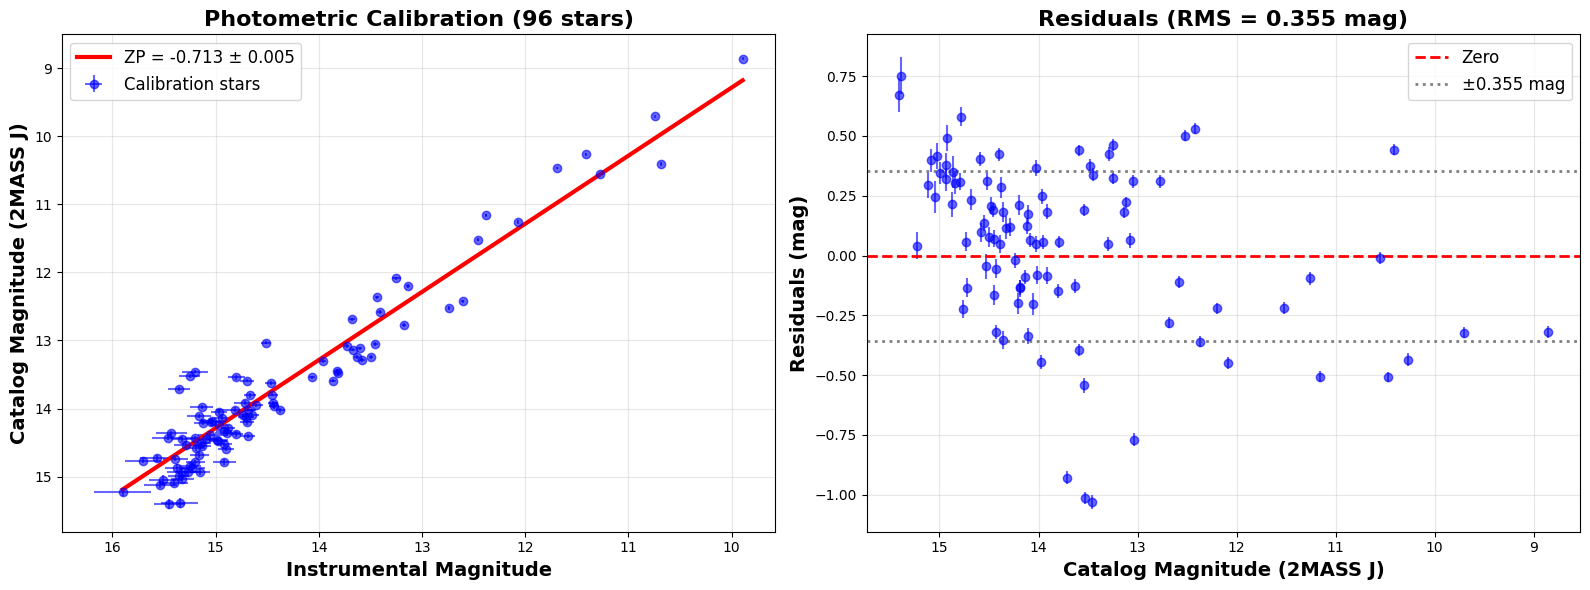

In [15]:
print("="*70)
print("STEP 9: Calibration Plots")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Calibration relation
ax1 = axes[0]
ax1.errorbar(mag_inst_final, mag_cat_final, 
             yerr=mag_cat_err_final, xerr=mag_inst_err_final,
             fmt='o', alpha=0.6, markersize=6, color='blue', label='Calibration stars')

# Fit line
x_fit = np.linspace(mag_inst_final.min(), mag_inst_final.max(), 100)
y_fit = x_fit + zeropoint
ax1.plot(x_fit, y_fit, 'r-', linewidth=3, label=f'ZP = {zeropoint:.3f} ± {zeropoint_err:.3f}')

ax1.set_xlabel('Instrumental Magnitude', fontsize=14, fontweight='bold')
ax1.set_ylabel(f'Catalog Magnitude (2MASS {filter_name})', fontsize=14, fontweight='bold')
ax1.set_title(f'Photometric Calibration ({n_used} stars)', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()
ax1.invert_yaxis()

# Plot 2: Residuals
ax2 = axes[1]
ax2.errorbar(mag_cat_final, residuals_final, yerr=mag_cat_err_final,
             fmt='o', alpha=0.6, markersize=6, color='blue')
ax2.axhline(0, color='r', linestyle='--', linewidth=2, label='Zero')
ax2.axhline(rms, color='gray', linestyle=':', linewidth=2, label=f'±{rms:.3f} mag')
ax2.axhline(-rms, color='gray', linestyle=':', linewidth=2)

ax2.set_xlabel(f'Catalog Magnitude (2MASS {filter_name})', fontsize=14, fontweight='bold')
ax2.set_ylabel('Residuals (mag)', fontsize=14, fontweight='bold')
ax2.set_title(f'Residuals (RMS = {rms:.3f} mag)', fontsize=16, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()

plt.tight_layout()
plt.savefig('photometric_calibration.png', dpi=150, bbox_inches='tight')
print("✓ Saved: photometric_calibration.png")
plt.show()

STEP 8b: Comparison of All Combinations and Strategies

Calibration Results (grouped by filter strategy):


ISOLATE+CENTRAL STRATEGY:
----------------------------------------------------------------------------------------------------
Threshold Aperture N_filtered N_used  Zeropoint    RMS 
--------- -------- ---------- ------ ------------ -----
     1.2σ    2.0px        116    116 -0.734±0.005 0.425
     1.2σ    3.0px        116    116 -0.325±0.005 0.479
     1.2σ    4.0px        116    113 -0.196±0.006 0.596
     1.2σ    5.0px        116    110 -0.138±0.006 0.669
     1.5σ    2.0px        101     99 -0.727±0.005 0.396
     1.5σ    3.0px        101    100 -0.321±0.005 0.458
     1.5σ    4.0px        101     99 -0.193±0.006 0.578
     1.5σ    5.0px        101     97 -0.133±0.006 0.657
     2.0σ    2.0px         93     91 -0.713±0.005 0.363
     2.0σ    3.0px         93     91 -0.310±0.005 0.405
     2.0σ    4.0px         93     89 -0.179±0.006 0.478
     2.0σ    5.0px         93     88 

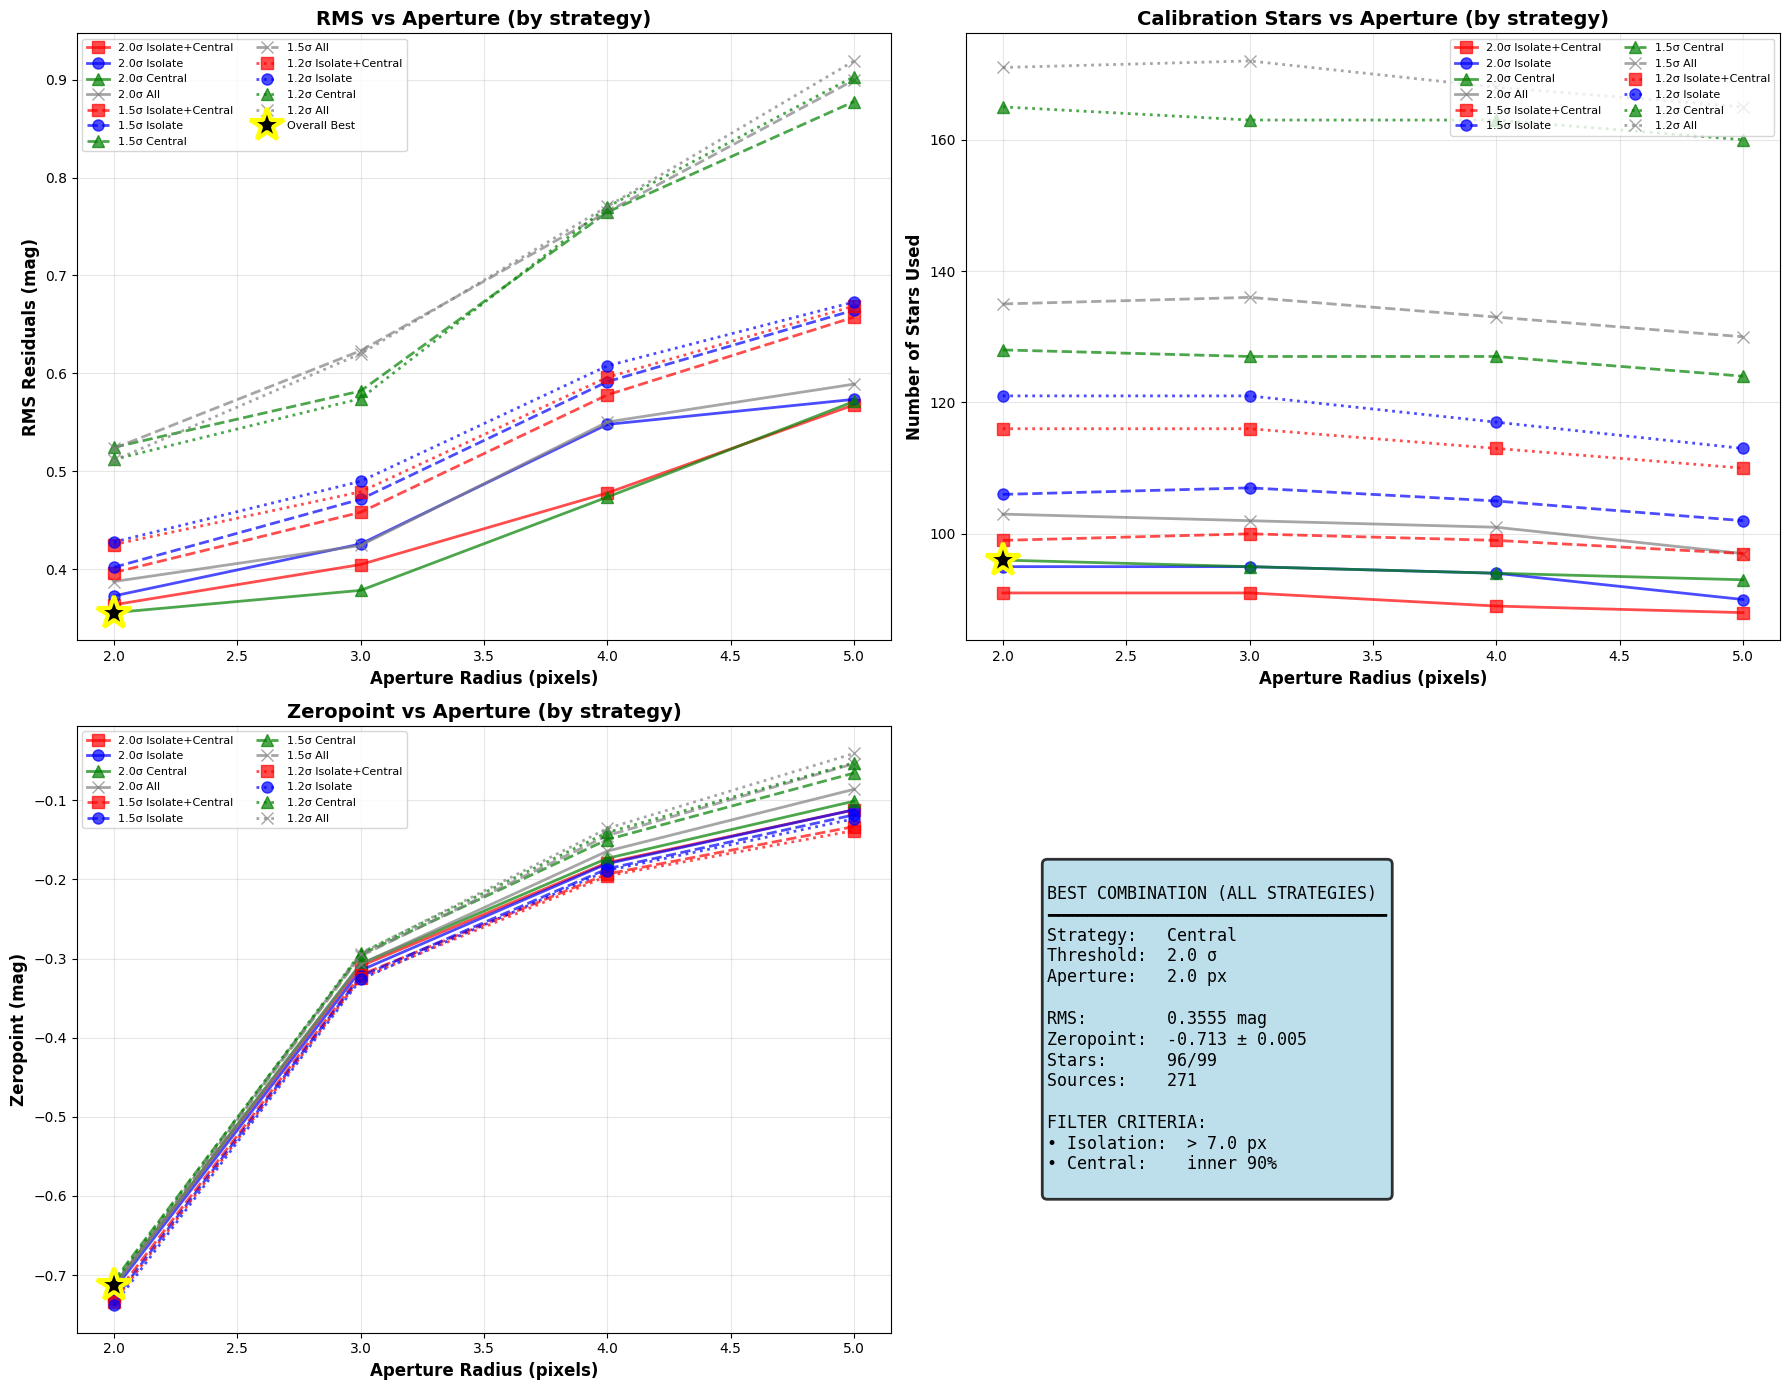


✓ Strategy comparison complete



In [16]:
print("="*70)
print("STEP 8b: Comparison of All Combinations and Strategies")
print("="*70)

# Create comparison table grouped by strategy
print("\nCalibration Results (grouped by filter strategy):\n")

for strategy_key, strategy_name in FILTER_STRATEGIES:
    print(f"\n{strategy_name.upper()} STRATEGY:")
    print("-" * 100)
    
    strategy_data = []
    for key, result in sorted(calibration_results.items()):
        if len(key) == 3 and key[2] == strategy_key:
            thresh, aper, _ = key
            strategy_data.append({
                'Threshold': f'{thresh}σ',
                'Aperture': f'{aper}px',
                'N_filtered': result['n_filtered'],
                'N_used': result['n_used'],
                'Zeropoint': f"{result['zeropoint']:.3f}±{result['zeropoint_err']:.3f}",
                'RMS': f"{result['rms']:.3f}"
            })
    
    if strategy_data:
        strategy_table = Table(strategy_data)
        print(strategy_table)
    else:
        print("  No results for this strategy")

# Identify best for each strategy
print(f"\n{'='*100}")
print("BEST RESULT FOR EACH STRATEGY:")
print(f"{'='*100}")

for strategy_key, strategy_name in FILTER_STRATEGIES:
    strategy_results = {k: v for k, v in calibration_results.items() 
                       if len(k) == 3 and k[2] == strategy_key}
    
    if strategy_results:
        best_for_strategy = min(strategy_results.keys(), 
                               key=lambda k: strategy_results[k]['rms'])
        result = strategy_results[best_for_strategy]
        thresh, aper, _ = best_for_strategy
        
        print(f"\n{strategy_name:16s}: {thresh}σ, {aper}px → RMS={result['rms']:.3f}, "
              f"ZP={result['zeropoint']:.3f}±{result['zeropoint_err']:.3f}, "
              f"N={result['n_used']}/{result['n_filtered']}")

print(f"\n{'='*100}")
print(f"OVERALL BEST: {best_result['filter_strategy_name']} - "
      f"{best_thresh}σ, {best_aper}px → RMS={best_result['rms']:.3f}")
print(f"{'='*100}\n")

# Plot comparison with colors for different strategies
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Define colors for strategies
strategy_colors = {
    'isolate+central': 'red',
    'isolate': 'blue',
    'central': 'green',
    'all': 'gray'
}

strategy_markers = {
    'isolate+central': 's',  # square
    'isolate': 'o',          # circle
    'central': '^',          # triangle
    'all': 'x'               # cross
}

# Group by threshold AND strategy
for thresh in SIGMA_THRESHOLDS:
    for strategy_key, strategy_name in FILTER_STRATEGIES:
        subset = [(k, v) for k, v in calibration_results.items() 
                 if len(k) == 3 and k[0] == thresh and k[2] == strategy_key]
        
        if len(subset) == 0:
            continue
        
        apertures = [k[1] for k, v in subset]
        rms_values = [v['rms'] for k, v in subset]
        n_stars = [v['n_used'] for k, v in subset]
        zeropoints = [v['zeropoint'] for k, v in subset]
        
        color = strategy_colors[strategy_key]
        marker = strategy_markers[strategy_key]
        linestyle = '-' if thresh == SIGMA_THRESHOLDS[0] else '--' if thresh == SIGMA_THRESHOLDS[1] else ':'
        label = f'{thresh}σ {strategy_name}'
        
        # Plot 1: RMS vs Aperture
        axes[0, 0].plot(apertures, rms_values, marker=marker, color=color,
                       linestyle=linestyle, markersize=8, linewidth=2, label=label, alpha=0.7)
        
        # Plot 2: N_stars vs Aperture
        axes[0, 1].plot(apertures, n_stars, marker=marker, color=color,
                       linestyle=linestyle, markersize=8, linewidth=2, label=label, alpha=0.7)
        
        # Plot 3: Zeropoint vs Aperture
        axes[1, 0].plot(apertures, zeropoints, marker=marker, color=color,
                       linestyle=linestyle, markersize=8, linewidth=2, label=label, alpha=0.7)

# Highlight overall best on all plots
axes[0, 0].plot(best_aper, best_result['rms'], 'k*', markersize=25, 
                markeredgewidth=3, markeredgecolor='yellow', label='Overall Best', zorder=10)
axes[0, 1].plot(best_aper, best_result['n_used'], 'k*', markersize=25,
                markeredgewidth=3, markeredgecolor='yellow', zorder=10)
axes[1, 0].plot(best_aper, best_result['zeropoint'], 'k*', markersize=25,
                markeredgewidth=3, markeredgecolor='yellow', zorder=10)

axes[0, 0].set_xlabel('Aperture Radius (pixels)', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('RMS Residuals (mag)', fontweight='bold', fontsize=12)
axes[0, 0].set_title('RMS vs Aperture (by strategy)', fontweight='bold', fontsize=14)
axes[0, 0].legend(fontsize=8, loc='best', ncol=2)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_xlabel('Aperture Radius (pixels)', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Number of Stars Used', fontweight='bold', fontsize=12)
axes[0, 1].set_title('Calibration Stars vs Aperture (by strategy)', fontweight='bold', fontsize=14)
axes[0, 1].legend(fontsize=8, loc='best', ncol=2)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_xlabel('Aperture Radius (pixels)', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Zeropoint (mag)', fontweight='bold', fontsize=12)
axes[1, 0].set_title('Zeropoint vs Aperture (by strategy)', fontweight='bold', fontsize=14)
axes[1, 0].legend(fontsize=8, loc='best', ncol=2)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Summary text with strategy info
ax_text = axes[1, 1]
ax_text.axis('off')
summary_text = f"""
BEST COMBINATION (ALL STRATEGIES)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Strategy:   {best_result['filter_strategy_name']}
Threshold:  {best_thresh} σ
Aperture:   {best_aper} px

RMS:        {best_result['rms']:.4f} mag
Zeropoint:  {best_result['zeropoint']:.3f} ± {best_result['zeropoint_err']:.3f}
Stars:      {best_result['n_used']}/{best_result['n_filtered']}
Sources:    {len(best_result['matched_result']['source_table'])}

FILTER CRITERIA:
• Isolation:  > {MIN_ISOLATION_DIST} px
• Central:    inner {CENTRAL_FRACTION*100:.0f}%
"""
ax_text.text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', 
             facecolor='lightblue', alpha=0.8, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.savefig('calibration_comparison_strategies.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved: calibration_comparison_strategies.png")
plt.show()

print("\n✓ Strategy comparison complete\n")

In [17]:
print("="*70)
print("STEP 10: Apply Calibration to All Sources")
print("="*70)

# Calculate calibrated magnitudes for all detected sources
source_table['mag_calibrated'] = source_table['mag_inst'] + zeropoint
source_table['mag_calibrated_err'] = source_table['mag_inst_err']

# Add RA, DEC for all sources
x_all = source_table['xcentroid'].value
y_all = source_table['ycentroid'].value
ra_all, dec_all = wcs.all_pix2world(x_all, y_all, 0)

source_table['ra'] = ra_all
source_table['dec'] = dec_all

# Add position errors (default based on FWHM)
if 'fwhm' in source_table.colnames:
    pos_err_pix = source_table['fwhm'] / 10.0  # ~0.1 FWHM
else:
    pos_err_pix = np.full(len(source_table), 0.5)  # 0.5 pixel default

source_table['ra_err'] = pos_err_pix * pixel_scale / 3600.0  # convert to degrees
source_table['dec_err'] = pos_err_pix * pixel_scale / 3600.0

print(f"  Calibrated {len(source_table)} sources")
print(f"  Magnitude range: {source_table['mag_calibrated'].min():.2f} to {source_table['mag_calibrated'].max():.2f}")

# Create final output table with all information
final_table = Table()
final_table['x'] = source_table['xcentroid']
final_table['y'] = source_table['ycentroid']
final_table['ra'] = source_table['ra']
final_table['dec'] = source_table['dec']
final_table['ra_err'] = source_table['ra_err']
final_table['dec_err'] = source_table['dec_err']
final_table['mag_inst'] = source_table['mag_inst']
final_table['mag_inst_err'] = source_table['mag_inst_err']
final_table['mag_cal'] = source_table['mag_calibrated']
final_table['mag_cal_err'] = source_table['mag_calibrated_err']
final_table['flux'] = source_table['flux']
final_table['flux_err'] = source_table['flux_err']
final_table['snr'] = source_table['snr']
final_table['aperture_radius'] = source_table['aperture_radius']

if 'fwhm' in source_table.colnames:
    final_table['fwhm'] = source_table['fwhm']

# Add catalog magnitudes for matched sources (initialize with NaN)
final_table['mag_cat'] = np.full(len(final_table), np.nan, dtype=float)
final_table['mag_cat_err'] = np.full(len(final_table), np.nan, dtype=float)

# Convert matched_catalog mag_err to float array (handle empty strings)
matched_mag_cat_err = np.zeros(len(matched_catalog))
for i, val in enumerate(matched_catalog['mag_err']):
    try:
        if val == '' or val is None or (isinstance(val, str) and val.strip() == ''):
            matched_mag_cat_err[i] = DEFAULT_ERROR_2MASS
        else:
            matched_mag_cat_err[i] = float(val)
    except (ValueError, TypeError):
        matched_mag_cat_err[i] = DEFAULT_ERROR_2MASS

# Now assign catalog magnitudes to matched sources
for i, det_idx in enumerate(matched_det_indices):
    # Find position in final_table
    match_idx = np.where((final_table['x'] == source_table['xcentroid'][det_idx]) & 
                         (final_table['y'] == source_table['ycentroid'][det_idx]))[0]
    if len(match_idx) > 0:
        final_table['mag_cat'][match_idx[0]] = matched_catalog['mag'][i]
        final_table['mag_cat_err'][match_idx[0]] = matched_mag_cat_err[i]

# Save catalog
output_file = FITS_FILE.replace('.fits', '_photometry.csv')
final_table.write(output_file, format='csv', overwrite=True)
print(f"\n✓ Saved photometry catalog: {output_file}")

print(f"\n{'='*70}")
print("PIPELINE COMPLETE!")
print(f"{'='*70}")
print(f"Filter: {filter_name}")
print(f"Zeropoint: {zeropoint:.3f} ± {zeropoint_err:.3f} mag")
print(f"RMS: {rms:.3f} mag")
print(f"Total sources detected: {len(final_table)}")
print(f"Calibration stars: {n_used}/{n_total}")
print(f"Image type: {'COADD' if is_coadd else 'SINGLE'} (NDITHERS={NDITHERS})")
print(f"{'='*70}\n")

# Display first 20 sources
print("First 20 sources:")
display_cols = ['x', 'y', 'ra', 'dec', 'mag_inst', 'mag_cal', 'mag_cal_err', 'mag_cat', 'snr']
print(final_table[display_cols][:20])

STEP 10: Apply Calibration to All Sources
  Calibrated 271 sources
  Magnitude range: 9.00 to 15.19

✓ Saved photometry catalog: /Users/matteoferro/Desktop/GRB/REM/process_REMIR/test_2026/proc/reduced/1A0538_66_330663_1_J_astro_photometry.csv

PIPELINE COMPLETE!
Filter: J
Zeropoint: -0.713 ± 0.005 mag
RMS: 0.355 mag
Total sources detected: 271
Calibration stars: 96/99
Image type: COADD (NDITHERS=5)

First 20 sources:
        x                  y                  ra               dec              mag_inst           mag_cal           mag_cal_err      mag_cat        snr        
------------------ ------------------ ----------------- ------------------ ------------------ ------------------ -------------------- ------- ------------------
211.80084586505168 12.024275609391175 83.91893136928275 -66.74983091871744 14.465703335632938 13.752520849290862 0.045960750861671194  13.164 23.623117212029175
 340.1950463599658 26.528283066222393 84.02787349495436 -66.76036951650565 15.138202528812956  1

Final Summary Plots
✓ Saved: photometry_summary.png


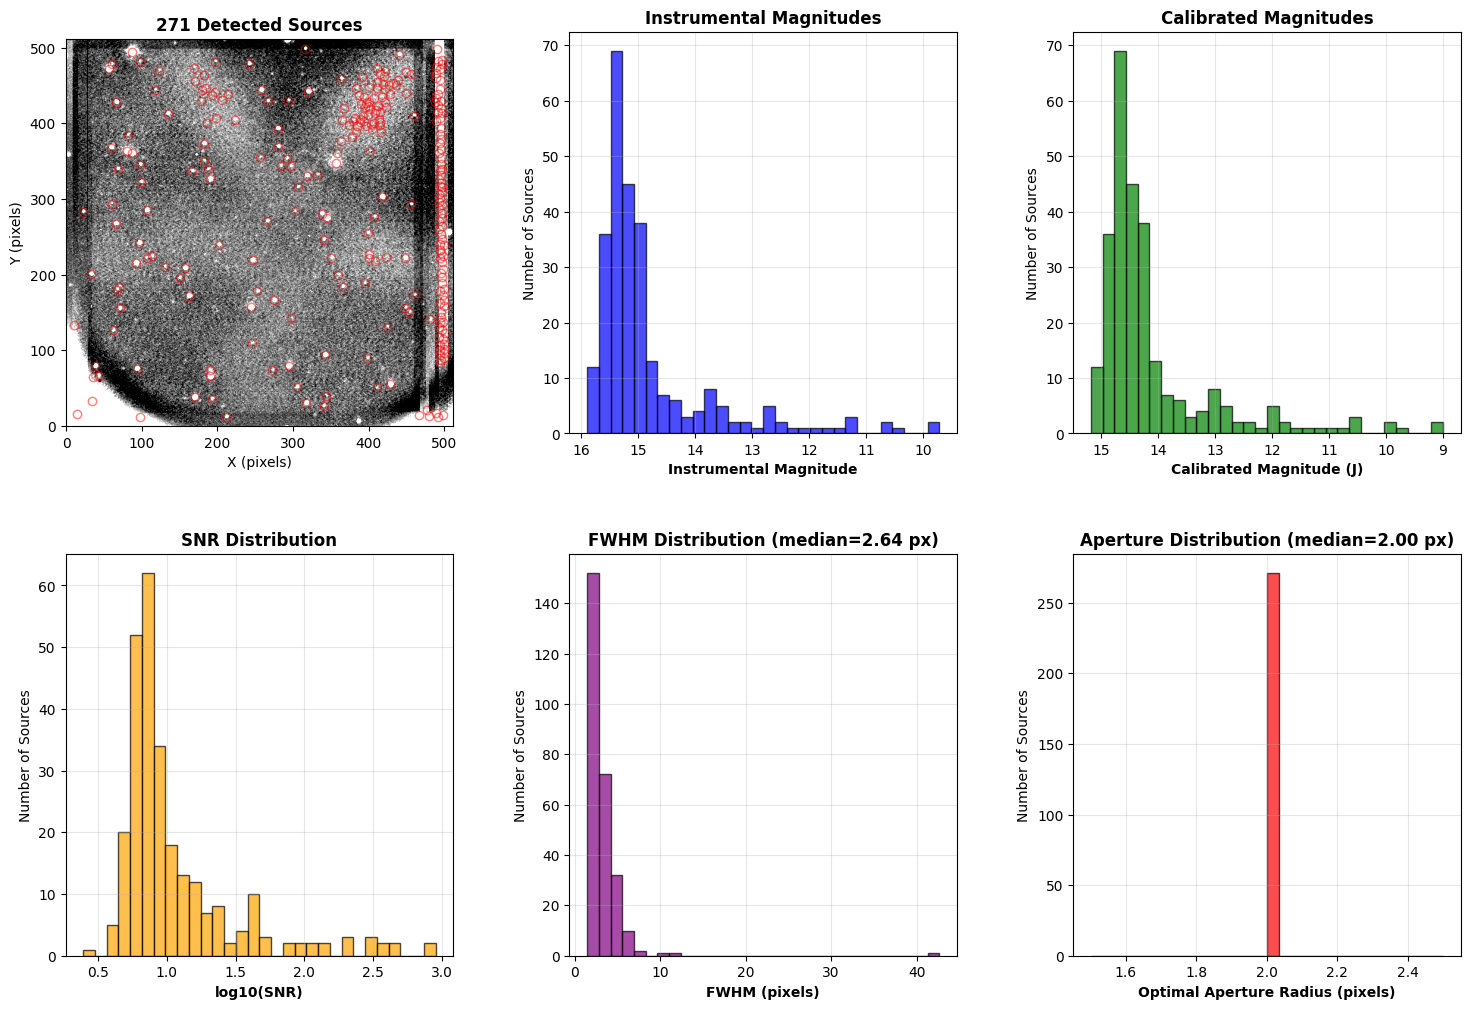


✓ All plots generated successfully


In [18]:
print("="*70)
print("Final Summary Plots")
print("="*70)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Image with detections
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(data_sub, origin='lower', cmap='gray',
           vmin=np.percentile(data_sub, 5), vmax=np.percentile(data_sub, 95))
ax1.plot(final_table['x'], final_table['y'], 'ro', 
         fillstyle='none', markersize=6, markeredgewidth=1, alpha=0.5)
ax1.set_title(f'{len(final_table)} Detected Sources', fontweight='bold')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')

# Plot 2: Magnitude histogram (instrumental)
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(final_table['mag_inst'], bins=30, alpha=0.7, edgecolor='black', color='blue')
ax2.set_xlabel('Instrumental Magnitude', fontweight='bold')
ax2.set_ylabel('Number of Sources')
ax2.set_title('Instrumental Magnitudes', fontweight='bold')
ax2.invert_xaxis()
ax2.grid(True, alpha=0.3)

# Plot 3: Magnitude histogram (calibrated)
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(final_table['mag_cal'], bins=30, alpha=0.7, edgecolor='black', color='green')
ax3.set_xlabel(f'Calibrated Magnitude ({filter_name})', fontweight='bold')
ax3.set_ylabel('Number of Sources')
ax3.set_title('Calibrated Magnitudes', fontweight='bold')
ax3.invert_xaxis()
ax3.grid(True, alpha=0.3)

# Plot 4: SNR histogram
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(np.log10(final_table['snr']), bins=30, alpha=0.7, edgecolor='black', color='orange')
ax4.set_xlabel('log10(SNR)', fontweight='bold')
ax4.set_ylabel('Number of Sources')
ax4.set_title('SNR Distribution', fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: FWHM histogram
ax5 = fig.add_subplot(gs[1, 1])
if 'fwhm' in final_table.colnames:
    ax5.hist(final_table['fwhm'], bins=30, alpha=0.7, edgecolor='black', color='purple')
    ax5.set_xlabel('FWHM (pixels)', fontweight='bold')
    ax5.set_ylabel('Number of Sources')
    ax5.set_title(f'FWHM Distribution (median={np.median(final_table["fwhm"]):.2f} px)', fontweight='bold')
    ax5.grid(True, alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'FWHM not available', ha='center', va='center', fontsize=14)
    ax5.set_xticks([])
    ax5.set_yticks([])

# Plot 6: Aperture radius histogram
ax6 = fig.add_subplot(gs[1, 2])
ax6.hist(final_table['aperture_radius'], bins=30, alpha=0.7, edgecolor='black', color='red')
ax6.set_xlabel('Optimal Aperture Radius (pixels)', fontweight='bold')
ax6.set_ylabel('Number of Sources')
ax6.set_title(f'Aperture Distribution (median={np.median(final_table["aperture_radius"]):.2f} px)', fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.savefig('photometry_summary.png', dpi=150, bbox_inches='tight')
print("✓ Saved: photometry_summary.png")
plt.show()

print("\n✓ All plots generated successfully")